### Plot latitude-longitude cross section at a selected pressure level

In [1]:
import warnings
from pathlib import Path

import iris
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
from tqdm.notebook import tqdm as tqdm

In [2]:
from aeolus.coord import interp_cube_from_height_to_pressure_levels
from aeolus.model import um
from aeolus.plot import subplot_label_generator

In [3]:
from util_commons import PLANETS, ROSE_SUITES

In [4]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, vcenter=None, clip=False):
        self.vcenter = vcenter
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.vcenter, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [5]:
def latex_float(f):
    float_str = "{0:.2e}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        sign = np.sign(f)
        if sign == -1:
            result = r"-$10^{{{1}}}$".format(base, int(exponent))
        if sign == 1:
            result = r"$10^{{{1}}}$".format(base, int(exponent))
        return result
    else:
        return float_str

In [6]:
warnings.filterwarnings("ignore", module="iris")
warnings.filterwarnings("ignore", module="aeolus")
iris.FUTURE.datum_support = True
rcParams["mathtext.default"] = "regular"

In [7]:
# Parameters
planet = "wasp96b"
path_to_project = Path.home() / "projects" / planet
tK = "tK_6"  # weak diffusion
t0 = -20  # last 200 days
Y, X = np.mgrid[-90:90:2, 0:360:2.5]  # lon-lat mesh
# Choose target pressure levels (!change diff_pc_kws, figname!)
# 1e3 Pa np.logspace(3, 4, 1); 1e2, 1e3, 1e4, 1e5 Pa np.logspace(2, 5, 4)
tgt_plevs = np.logspace(3, 4, 1)

In [8]:
vrbls = {}
for exp in ["equilibrium", "kinetics"]:
    vrbls[exp] = {}
    for mdh in ["mdh_0", "mdh_1"]:
        vrbls[exp][mdh] = {}
        # Load data and extract the last 200 days
        fpath = ROSE_SUITES[planet][exp][mdh][tK]["dir_for_data"] / "merged"
        fname = f"{ROSE_SUITES[planet][exp][mdh][tK]['rose_suite']}.nc"
        pres = iris.load_cube(fpath / fname, um.pres)[t0:, ...]
        temp = iris.load_cube(fpath / fname, um.temp)[t0:, ...]
        u = iris.load_cube(fpath / fname, "x_wind")[t0:, ...]
        v = iris.load_cube(fpath / fname, "y_wind")[t0:, ...]
        w = iris.load_cube(fpath / fname, "upward_air_velocity")[t0:, ...]
        ch4 = iris.load_cube(fpath / fname, "CH4 mole fraction")[t0:, ...]
        nh3 = iris.load_cube(fpath / fname, "NH3 mole fraction")[t0:, ...]
        hcn = iris.load_cube(fpath / fname, "HCN mole fraction")[t0:, ...]
        # Regrid v wind to u wind coordinates
        v_rgrd = v.regrid(u, iris.analysis.Linear())
        # Interpolate to the target pressure level
        for tgt_plev, tgt_plev_v in tqdm(zip(tgt_plevs, [f"{i:1.0e}" for i in tgt_plevs])):
            temp_plev = interp_cube_from_height_to_pressure_levels(
                temp,
                pres,
                tgt_plev,
                model=um,
            )
            u_plev = interp_cube_from_height_to_pressure_levels(
                u,
                pres,
                tgt_plev,
                model=um,
            )
            v_plev = interp_cube_from_height_to_pressure_levels(
                v_rgrd,
                pres,
                tgt_plev,
                model=um,
            )
            w_plev = interp_cube_from_height_to_pressure_levels(
                w,
                pres,
                tgt_plev,
                model=um,
            )
            ch4_plev = interp_cube_from_height_to_pressure_levels(
                ch4,
                pres,
                tgt_plev,
                model=um,
            )
            nh3_plev = interp_cube_from_height_to_pressure_levels(
                nh3,
                pres,
                tgt_plev,
                model=um,
            )
            hcn_plev = interp_cube_from_height_to_pressure_levels(
                hcn,
                pres,
                tgt_plev,
                model=um,
            )
            # Calculate mean over the last 200 days
            temp_plev_mean = temp_plev.collapsed(["time"], iris.analysis.MEAN)
            u_plev_mean = u_plev.collapsed(["time"], iris.analysis.MEAN)
            v_plev_mean = v_plev.collapsed(["time"], iris.analysis.MEAN)
            w_plev_mean = w_plev.collapsed(["time"], iris.analysis.MEAN)
            ch4_plev_mean = ch4_plev.collapsed(["time"], iris.analysis.MEAN)
            nh3_plev_mean = nh3_plev.collapsed(["time"], iris.analysis.MEAN)
            hcn_plev_mean = hcn_plev.collapsed(["time"], iris.analysis.MEAN)
            # Assemble data
            vrbls[exp][mdh][tgt_plev_v] = {
                "temp_plev_mean": temp_plev_mean,
                "u_plev_mean": u_plev_mean,
                "v_plev_mean": v_plev_mean,
                "w_plev_mean": w_plev_mean,
                "ch4_plev_mean": ch4_plev_mean,
                "nh3_plev_mean": nh3_plev_mean,
                "hcn_plev_mean": hcn_plev_mean,
            }

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [9]:
# Evening minus morning limb temperature difference
for exp in ["equilibrium", "kinetics"]:
    for mdh in ["mdh_0", "mdh_1"]:
        eve_m_mor = (
            vrbls[exp][mdh][tgt_plev_v]["temp_plev_mean"].data[:, 72].mean()
            - vrbls[exp][mdh][tgt_plev_v]["temp_plev_mean"].data[:, 36].mean()
        )
        print(exp[0:3], mdh, eve_m_mor)

equ mdh_0 256.3378736024631
equ mdh_1 438.6101386249171
kin mdh_0 253.6134810167557
kin mdh_1 485.72218048639263


In [10]:
# Average between equilibrium and kinetics simulations at 1e3 Pa
(256.3378736024631 + 253.6134810167557) / 2

254.9756773096094

In [11]:
(438.6101386249171 + 485.72218048639263) / 2

462.1661595556549

In [12]:
# Find min max
temp_cmmn_mins, temp_cmmn_maxs = [], []
wspd_cmmn_maxs = []
w_cmmn_mins, w_cmmn_maxs = [], []
ch4_cmmn_mins, ch4_cmmn_maxs = [], []
nh3_cmmn_mins, nh3_cmmn_maxs = [], []
hcn_cmmn_mins, hcn_cmmn_maxs = [], []
for exp in ["equilibrium", "kinetics"]:
    for mdh in ["mdh_0", "mdh_1"]:
        for tgt_plev_v in [f"{i:1.0e}" for i in tgt_plevs]:
            TEMP = vrbls[exp][mdh][tgt_plev_v]["temp_plev_mean"].data
            U = vrbls[exp][mdh][tgt_plev_v]["u_plev_mean"].data
            V = vrbls[exp][mdh][tgt_plev_v]["v_plev_mean"].data
            W = vrbls[exp][mdh][tgt_plev_v]["w_plev_mean"].data
            CH4 = vrbls[exp][mdh][tgt_plev_v]["ch4_plev_mean"].data
            NH3 = vrbls[exp][mdh][tgt_plev_v]["nh3_plev_mean"].data
            HCN = vrbls[exp][mdh][tgt_plev_v]["hcn_plev_mean"].data
            WSPD = np.sqrt(U**2 + V**2)
            temp_cmmn_mins.append(TEMP.min())
            temp_cmmn_maxs.append(TEMP.max())
            wspd_cmmn_maxs.append(WSPD.max())
            w_cmmn_mins.append(W.min())
            w_cmmn_maxs.append(W.max())
            ch4_cmmn_mins.append(CH4.min())
            ch4_cmmn_maxs.append(CH4.max())
            nh3_cmmn_mins.append(NH3.min())
            nh3_cmmn_maxs.append(NH3.max())
            hcn_cmmn_mins.append(HCN.min())
            hcn_cmmn_maxs.append(HCN.max())
temp_cmmn_min = np.array(temp_cmmn_mins).min()
temp_cmmn_max = np.array(temp_cmmn_maxs).max()
wspd_cmmn_max = np.array(wspd_cmmn_maxs).max()
w_cmmn_min = np.array(w_cmmn_mins).min()
w_cmmn_max = np.array(w_cmmn_maxs).max()
ch4_cmmn_min = 10 ** np.ceil(np.log10(np.array(ch4_cmmn_mins).min()))
ch4_cmmn_max = 10 ** np.ceil(np.log10(np.array(ch4_cmmn_maxs).max()))
nh3_cmmn_min = 10 ** np.ceil(np.log10(np.array(nh3_cmmn_mins).min()))
nh3_cmmn_max = 10 ** np.ceil(np.log10(np.array(nh3_cmmn_maxs).max()))
hcn_cmmn_min = 10 ** np.ceil(np.log10(np.array(hcn_cmmn_mins).min()))
hcn_cmmn_max = 10 ** np.ceil(np.log10(np.array(hcn_cmmn_maxs).max()))
# Set colorbar limits for w
plt_w_cmmn = round(np.max(np.abs([w_cmmn_min, w_cmmn_max])) / 10) * 10

In [13]:
def plt_latlon_var_stream_at_plevs(var):
    """Plot latitude-longitude cross section at a selected pressure level with variable difference."""
    # Options
    if var == "temp":
        var_norm = colors.Normalize(vmin=temp_cmmn_min, vmax=temp_cmmn_max)
        cmap = "cividis"  # "gist_gray"
        cbar_lbl_main = "(a-d) Temperature [K]"
        cbar_lbl_diff = "(e-h) Temperature difference [K]"
        diff_pc_kws = {
            # 1e3 Pa 300 K; 1e2-1e5 Pa 400 K
            "norm": MidpointNormalize(vcenter=0, vmin=-300, vmax=300),
            "cmap": "RdBu_r",
        }
        diff_cr_kws = {
            "colors": "grey",
            "linewidths": 1,
        }
        cr_fmt = None
        folder = "circulation"
    if var == "w":
        var_norm = MidpointNormalize(vcenter=0, vmin=-plt_w_cmmn, vmax=plt_w_cmmn)
        cmap = "RdBu_r"
        cbar_lbl_main = "(a-d) Vertical wind speed [$m s^{-1}$]"
        cbar_lbl_diff = "(e-h) Vertical wind speed difference [$m s^{-1}$]"
        diff_pc_kws = {
            # 1e3 Pa 20 m s-1; 1e2-1e5 Pa 30 m s-1
            "norm": MidpointNormalize(vcenter=0, vmin=-20, vmax=20),
            "cmap": "RdBu_r",
        }
        diff_cr_kws = {
            "colors": "grey",
            "linewidths": 1,
        }
        cr_fmt = None
        folder = "circulation"
    if var in ["ch4", "hcn", "nh3"]:
        cmap = "YlGn"
        diff_pc_kws = {
            "norm": colors.SymLogNorm(linthresh=1e-12, vmin=-1e-2, vmax=1e-2),
            "cmap": "RdBu_r",
        }
        diff_cr_kws = {
            "levels": np.concatenate(
                [-np.logspace(-12, -2, 11)[::-1], [0], np.logspace(-12, -2, 11)]
            ),
            "colors": "grey",
            "linewidths": 1,
        }
        cr_fmt = "%.0e"
        folder = "chemistry"
        if var == "ch4":
            var_norm = colors.LogNorm(vmin=ch4_cmmn_min, vmax=ch4_cmmn_max)
            cbar_lbl_main = "(a-d) $CH_4$ mole fraction"
            cbar_lbl_diff = "(e-h) $CH_4$ mole fraction difference"
        if var == "nh3":
            var_norm = colors.LogNorm(vmin=nh3_cmmn_min, vmax=nh3_cmmn_max)
            cbar_lbl_main = "(a-d) $NH_3$ mole fraction"
            cbar_lbl_diff = "(e-h) $NH_3$ mole fraction difference"
        if var == "hcn":
            var_norm = colors.LogNorm(vmin=hcn_cmmn_min, vmax=hcn_cmmn_max)
            cbar_lbl_main = "(a-d) HCN mole fraction"
            cbar_lbl_diff = "(e-h) HCN mole fraction difference"

    # Plot
    for tgt_plev_v in tqdm([f"{i:1.0e}" for i in tgt_plevs]):
        fig, axs = plt.subplots(
            3, 3, figsize=(10.5, 6), sharex=True, sharey=True, constrained_layout=True
        )
        # Variable and horizontal wind
        iletters = subplot_label_generator()
        for mdh, axrow in zip(["mdh_0", "mdh_1"], axs[0:2, 0:2]):
            for exp, ax in zip(["equilibrium", "kinetics"], axrow):
                # Variable
                plt_var = vrbls[exp][mdh][tgt_plev_v][f"{var}_plev_mean"].data
                p0 = ax.pcolormesh(X, Y, plt_var, norm=var_norm, cmap=cmap, rasterized=True)
                # Horizontal wind
                U = vrbls[exp][mdh][tgt_plev_v]["u_plev_mean"].data
                V = vrbls[exp][mdh][tgt_plev_v]["v_plev_mean"].data
                WSPD = np.sqrt(U**2 + V**2)
                lw = 3 * WSPD / wspd_cmmn_max
                ax.streamplot(X, Y, U, V, density=[1, 1], linewidth=lw, color="k")
                # Common
                ax.set_title(f"({next(iletters)}) {exp.capitalize()}", loc="left")
                ax.set_title(f"[M/H]={mdh[-1]}", loc="right")
        # Variable colorbar
        cax_var = fig.add_axes([2.17 * 1 / 3, 0.27, 1 / 4, 0.01])
        cax_var_bar = fig.colorbar(
            p0, ax=axrow, cax=cax_var, label=cbar_lbl_main, orientation="horizontal", shrink=0.7
        )
        # Variable difference
        plt_var_equ_mdh_0 = vrbls["equilibrium"]["mdh_0"][tgt_plev_v][f"{var}_plev_mean"]
        plt_var_kin_mdh_0 = vrbls["kinetics"]["mdh_0"][tgt_plev_v][f"{var}_plev_mean"]
        plt_var_equ_mdh_1 = vrbls["equilibrium"]["mdh_1"][tgt_plev_v][f"{var}_plev_mean"]
        plt_var_kin_mdh_1 = vrbls["kinetics"]["mdh_1"][tgt_plev_v][f"{var}_plev_mean"]
        plt_var_equ_mdh_1_m_equ_mdh_0 = (plt_var_equ_mdh_1 - plt_var_equ_mdh_0).data
        plt_var_kin_mdh_1_m_kin_mdh_0 = (plt_var_kin_mdh_1 - plt_var_kin_mdh_0).data
        plt_var_kin_mdh_0_m_equ_mdh_0 = (plt_var_kin_mdh_0 - plt_var_equ_mdh_0).data
        plt_var_kin_mdh_1_m_equ_mdh_1 = (plt_var_kin_mdh_1 - plt_var_equ_mdh_1).data
        # Variable difference plot
        p20 = axs[2, 0].pcolormesh(
            X, Y, plt_var_equ_mdh_1_m_equ_mdh_0, **diff_pc_kws, rasterized=True
        )
        p20c = axs[2, 0].contour(X, Y, plt_var_equ_mdh_1_m_equ_mdh_0, **diff_cr_kws)
        axs[2, 0].clabel(p20c, p20c.levels, inline=True, fontsize=6.0, fmt=cr_fmt)
        axs[2, 0].set_title("(e)", loc="left")
        axs[2, 0].set_title(f"Equ [M/H]=1 - Equ [M/H]=0", loc="center")

        p21 = axs[2, 1].pcolormesh(
            X, Y, plt_var_kin_mdh_1_m_kin_mdh_0, **diff_pc_kws, rasterized=True
        )
        p21c = axs[2, 1].contour(X, Y, plt_var_kin_mdh_1_m_kin_mdh_0, **diff_cr_kws)
        axs[2, 1].clabel(p21c, p21c.levels, inline=True, fontsize=6, fmt=cr_fmt)
        axs[2, 1].set_title("(f)", loc="left")
        axs[2, 1].set_title(f"Kin [M/H]=1 - Kin [M/H]=0", loc="center")

        p02 = axs[0, 2].pcolormesh(
            X, Y, plt_var_kin_mdh_0_m_equ_mdh_0, **diff_pc_kws, rasterized=True
        )
        p02c = axs[0, 2].contour(X, Y, plt_var_kin_mdh_0_m_equ_mdh_0, **diff_cr_kws)
        axs[0, 2].clabel(p02c, p02c.levels, inline=True, fontsize=6, fmt=cr_fmt)
        axs[0, 2].set_title("(g)", loc="left")
        axs[0, 2].set_title(f"Kin [M/H]=0 - Equ [M/H]=0", loc="center")

        p12 = axs[1, 2].pcolormesh(
            X, Y, plt_var_kin_mdh_1_m_equ_mdh_1, **diff_pc_kws, rasterized=True
        )
        p12c = axs[1, 2].contour(X, Y, plt_var_kin_mdh_1_m_equ_mdh_1, **diff_cr_kws)
        axs[1, 2].clabel(p12c, p12c.levels, inline=True, fontsize=6, fmt=cr_fmt)
        axs[1, 2].set_title("(h)", loc="left")
        axs[1, 2].set_title(f"Kin [M/H]=1 - Equ [M/H]=1", loc="center")
        axs[2, 2].axis("off")
        # Variable difference colorbar
        cax_diff = fig.add_axes([2.17 * 1 / 3, 0.17, 1 / 4, 0.01])
        cax_diff_bar = fig.colorbar(
            p20,
            ax=axs[2, 0],
            cax=cax_diff,
            label=cbar_lbl_diff,
            orientation="horizontal",
            shrink=0.7,
        )
        if var in ["ch4", "hcn", "nh3"]:
            cax_diff_bar.set_ticks(
                np.concatenate([-np.logspace(-12, -2, 11)[::-1], [0], np.logspace(-12, -2, 11)])[
                    1::4
                ]
            )
            cax_diff_bar.set_ticklabels(
                [
                    latex_float(i)
                    for i in np.concatenate(
                        [-np.logspace(-12, -2, 11)[::-1], [0], np.logspace(-12, -2, 11)]
                    )[1::4]
                ]
            )
        # Common
        for iax in axs.flatten()[0:-1]:
            iax.set_xlim(left=0)
            iax.plot(180, 0, markersize=4, marker="x", color="C3")
            iax.axvline(x=90, color="C0", linestyle="dotted")
            iax.axvline(x=270, color="C1", linestyle="dotted")
            if iax.get_subplotspec().is_first_col():
                iax.set_ylabel("Latitude")
        for iax in [axs[2, 0], axs[2, 1]]:
            iax.set_xlabel("Longitude")
        fig.suptitle(
            f"{PLANETS[planet]['tex']}: latitude-longitude cross section at $10^{tgt_plev_v[-1]}$ Pa"
        )
        # Add scale_cmmn?
        figname_png = f"{planet}_hwind_{var}_at_pres{tgt_plev_v}Pa_w_diffs.png"
        figname_pdf = f"{planet}_hwind_{var}_at_pres{tgt_plev_v}Pa_w_diffs.pdf"
        fig.savefig(path_to_project / folder / "cross_section_latlon_at_plevs" / figname_png)
        fig.savefig(
            path_to_project / folder / "cross_section_latlon_at_plevs" / figname_pdf, format="pdf"
        )

  0%|          | 0/1 [00:00<?, ?it/s]

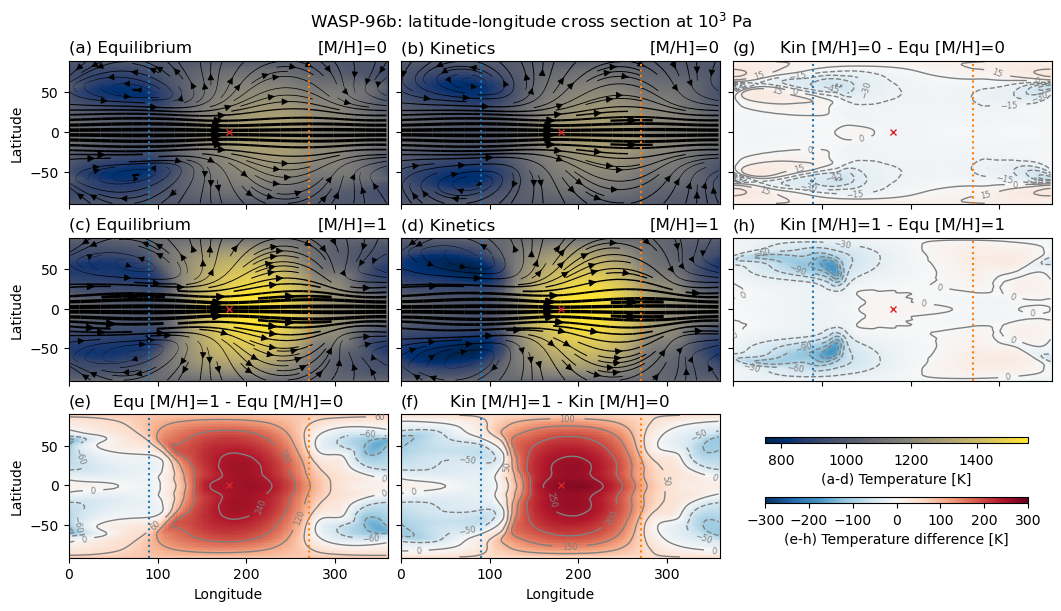

In [14]:
plt_latlon_var_stream_at_plevs("temp")

  0%|          | 0/1 [00:00<?, ?it/s]

/tmp/ipykernel_13609/3936516794.py:111: UserWarning: No contour levels were found within the data range.
  p21c = axs[2, 1].contour(X, Y, plt_var_kin_mdh_1_m_kin_mdh_0, **diff_cr_kws)


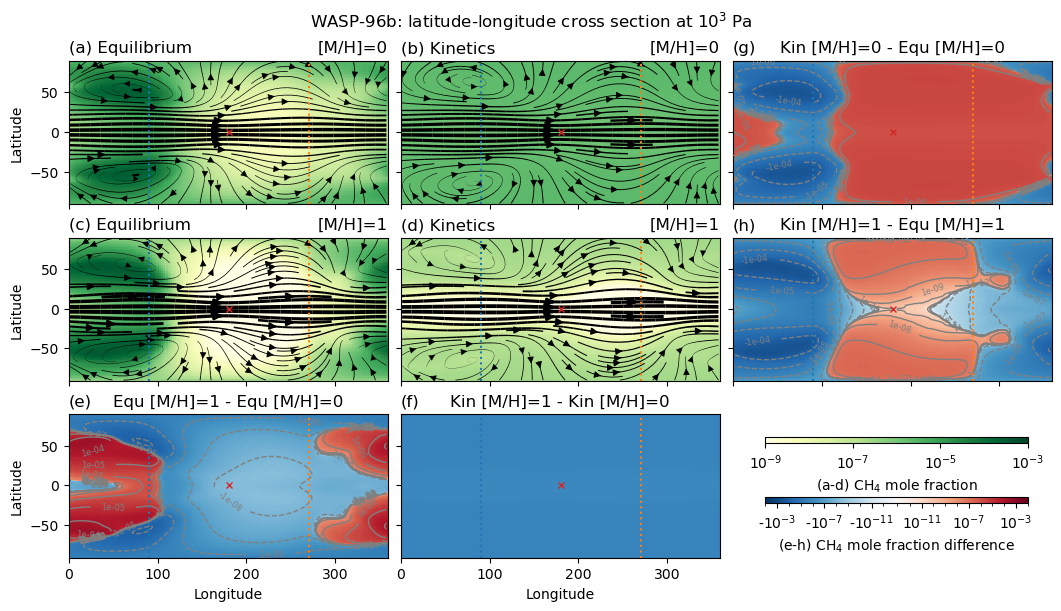

In [16]:
plt_latlon_var_stream_at_plevs("ch4")

  0%|          | 0/1 [00:00<?, ?it/s]

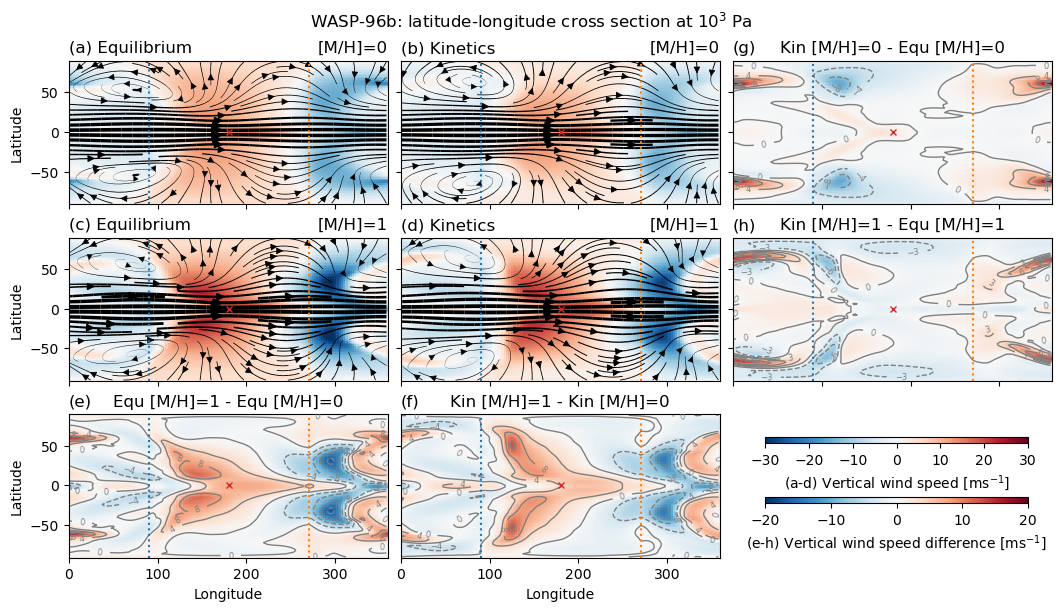

In [15]:
plt_latlon_var_stream_at_plevs("w")

  0%|          | 0/1 [00:00<?, ?it/s]

/tmp/ipykernel_13609/3936516794.py:111: UserWarning: No contour levels were found within the data range.
  p21c = axs[2, 1].contour(X, Y, plt_var_kin_mdh_1_m_kin_mdh_0, **diff_cr_kws)
/tmp/ipykernel_13609/3936516794.py:119: UserWarning: No contour levels were found within the data range.
  p02c = axs[0, 2].contour(X, Y, plt_var_kin_mdh_0_m_equ_mdh_0, **diff_cr_kws)


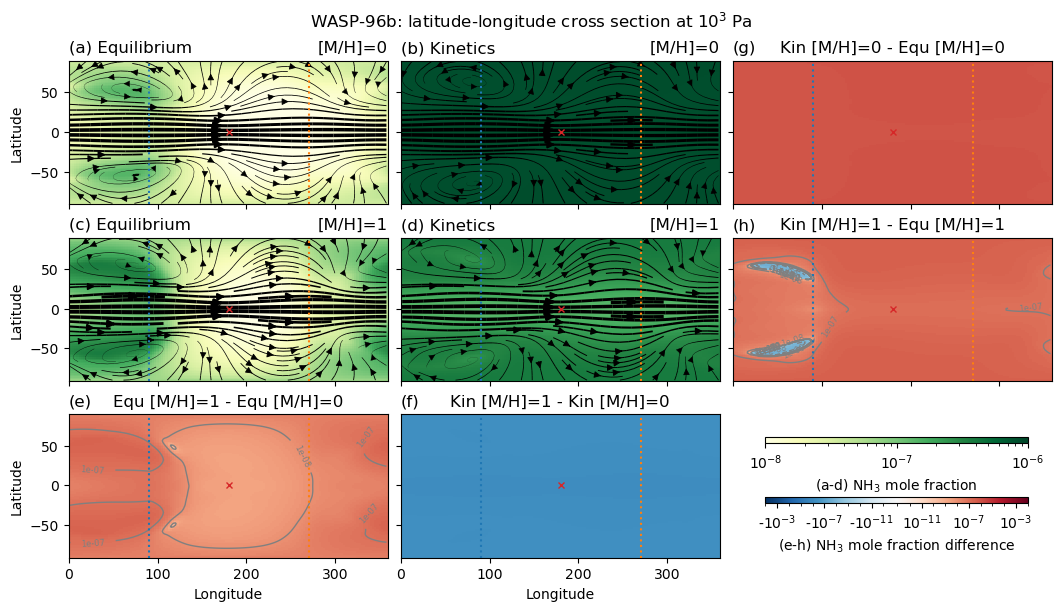

In [17]:
plt_latlon_var_stream_at_plevs("nh3")

  0%|          | 0/1 [00:00<?, ?it/s]

/tmp/ipykernel_13609/3936516794.py:103: UserWarning: No contour levels were found within the data range.
  p20c = axs[2, 0].contour(X, Y, plt_var_equ_mdh_1_m_equ_mdh_0, **diff_cr_kws)
/tmp/ipykernel_13609/3936516794.py:111: UserWarning: No contour levels were found within the data range.
  p21c = axs[2, 1].contour(X, Y, plt_var_kin_mdh_1_m_kin_mdh_0, **diff_cr_kws)
/tmp/ipykernel_13609/3936516794.py:119: UserWarning: No contour levels were found within the data range.
  p02c = axs[0, 2].contour(X, Y, plt_var_kin_mdh_0_m_equ_mdh_0, **diff_cr_kws)
/tmp/ipykernel_13609/3936516794.py:127: UserWarning: No contour levels were found within the data range.
  p12c = axs[1, 2].contour(X, Y, plt_var_kin_mdh_1_m_equ_mdh_1, **diff_cr_kws)


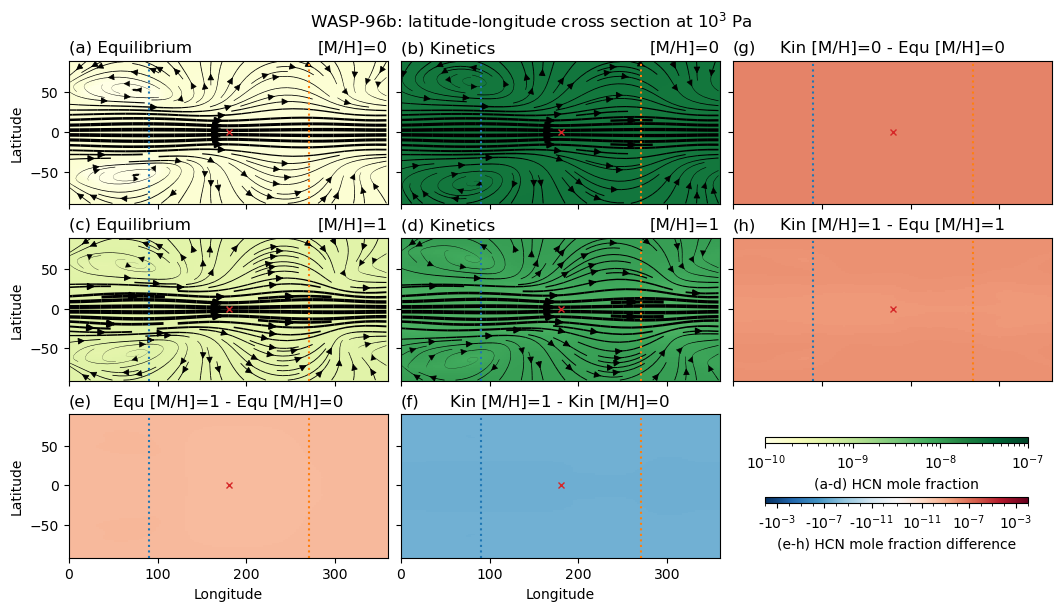

In [18]:
plt_latlon_var_stream_at_plevs("hcn")